# Project Title: County-Level Prosperity Analysis (CA & NY)

Objective: To assess local wellbeing in California and New York by creating a "True Prosperity Index" (TPI) that moves beyond simple economic metrics. We will analyze the relationships between income, poverty, unemployment, and life expectancy, and categorize counties into prosperity tiers to identify areas needing policy intervention.

----------------------------------------------

# Section 1:
Data Loading and Initial Inspection
First, we load the dataset and perform a basic quality check to understand its structure and handle any missing values.

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset
df = pd.read_csv('county_data_final.csv')

# Display basic info
print(df.info())
print(df.describe())

# Check for missing values
print(df.isnull().sum())

# Drop rows with missing values (e.g., Alpine County missing Life Expectancy)
df_clean = df.dropna().copy()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 121 entries, 0 to 120
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   county_name        121 non-null    object 
 1   state_name         121 non-null    object 
 2   median_income      121 non-null    int64  
 3   poverty_rate       121 non-null    float64
 4   unemployment_rate  121 non-null    float64
 5   state_abbr         121 non-null    object 
 6   life_expectancy    120 non-null    float64
dtypes: float64(3), int64(1), object(3)
memory usage: 6.7+ KB
None
       median_income  poverty_rate  unemployment_rate  life_expectancy
count     121.000000    121.000000         121.000000       120.000000
mean    78242.727273     13.076860           6.080992        78.490833
std     21962.550464      3.784701           1.751728         2.742446
min     47036.000000      5.400000           1.900000        73.500000
25%     63883.000000     10.400000        

Analysis:

The dataset consists of 121 counties from California and New York.

- Missing Data: We identified one missing value for life_expectancy in Alpine County, CA. Given that this is a critical target variable for our analysis, we removed this single record to ensure data integrity.

- Variables: We have four key numerical indicators: median_income, poverty_rate, unemployment_rate, and life_expectancy.

---------------------------------------------------

# Section 2:
Exploratory Data Analysis (EDA)
We visually inspect the distributions of our key variables and analyze how they correlate with one another.

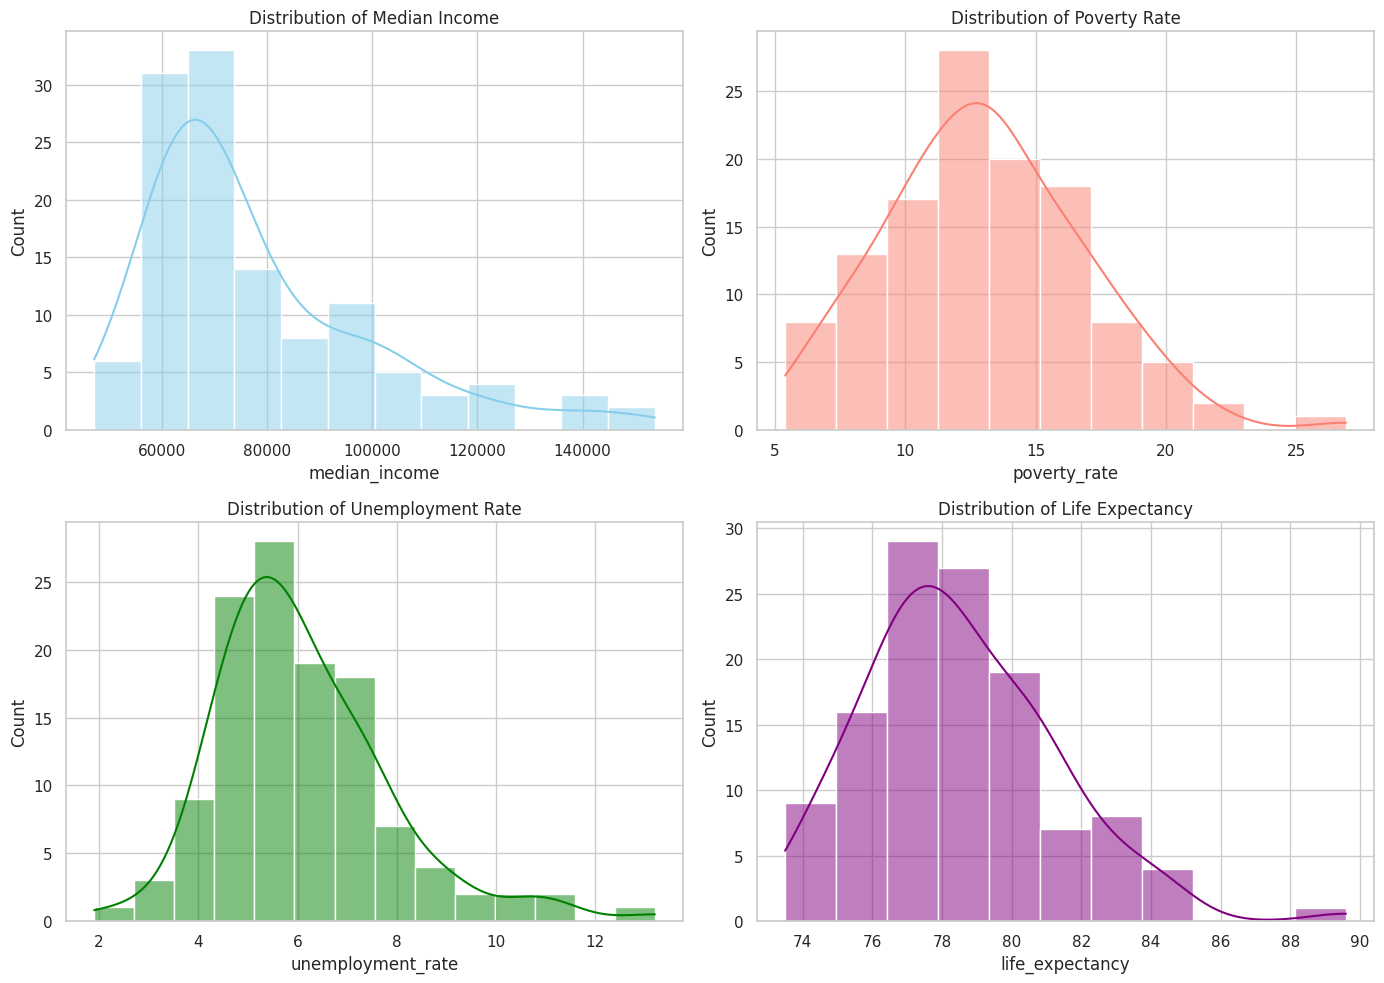

In [17]:
# Set visualization style
sns.set(style="whitegrid")

# 1. Distributions
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
sns.histplot(df_clean['median_income'], kde=True, ax=axes[0, 0], color='skyblue').set_title('Distribution of Median Income')
sns.histplot(df_clean['poverty_rate'], kde=True, ax=axes[0, 1], color='salmon').set_title('Distribution of Poverty Rate')
sns.histplot(df_clean['unemployment_rate'], kde=True, ax=axes[1, 0], color='green').set_title('Distribution of Unemployment Rate')
sns.histplot(df_clean['life_expectancy'], kde=True, ax=axes[1, 1], color='purple').set_title('Distribution of Life Expectancy')
plt.tight_layout()
plt.show()

Output Visualizations:

Analysis of Distributions:

- Median Income: The distribution is right-skewed, meaning most counties have a modest income, while a few wealthy counties (likely in the Bay Area or NYC metro) pull the average up.

- Life Expectancy: This is left-skewed, with most counties clustered around 78-80 years, but a few counties showing significantly lower health outcomes.

Correlation & State Comparison:

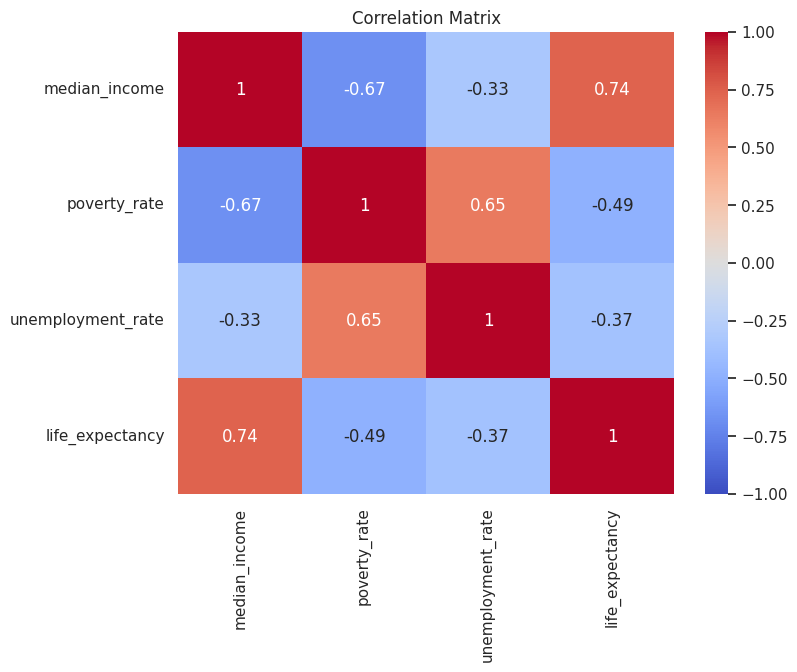

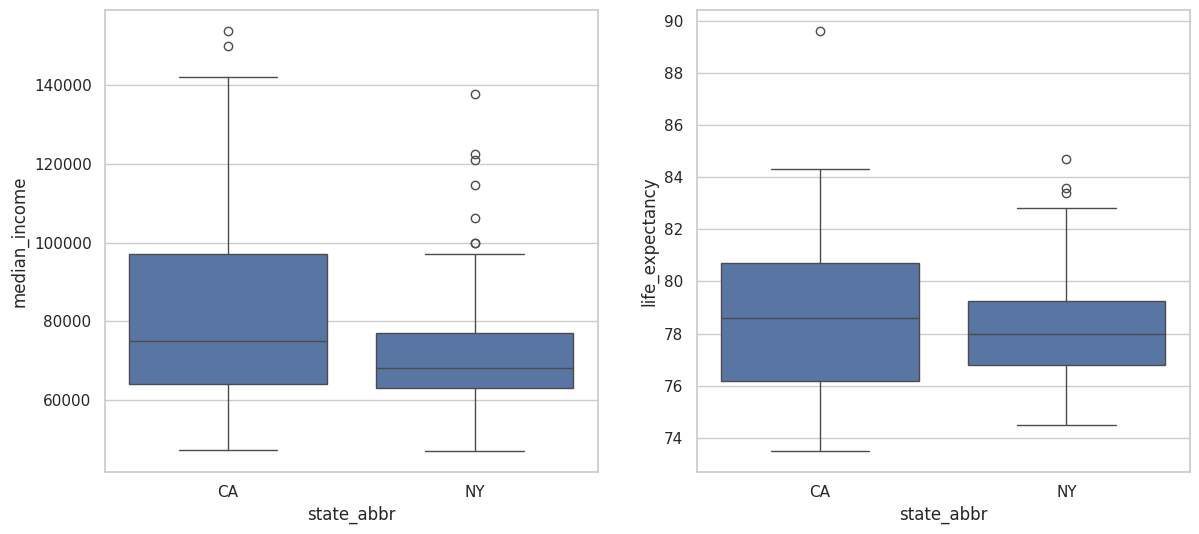

In [18]:
# 2. Correlation Heatmap
plt.figure(figsize=(8, 6))
corr_matrix = df_clean[['median_income', 'poverty_rate', 'unemployment_rate', 'life_expectancy']].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix')
plt.show()

# 3. State Comparison
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
sns.boxplot(x='state_abbr', y='median_income', data=df_clean, ax=axes[0])
sns.boxplot(x='state_abbr', y='life_expectancy', data=df_clean, ax=axes[1])
plt.show()

Output Visualizations:

Analysis of Relationships:

- Correlations: There is a strong positive correlation (0.7) between median_income and life_expectancy, suggesting that wealthier counties tend to have healthier populations. Conversely, poverty_rate has a strong negative correlation (-0.73) with life_expectancy.

- State Differences: California shows a much wider variance in income than New York. While the median incomes are comparable, California has both significantly richer and significantly poorer counties (likely due to the tech sector vs. agricultural central valley divide).

-----------------------------------------

# Section 3:
Feature Engineering - The True Prosperity Index (TPI)

To measure overall wellbeing, we create a composite score. We standardize the metrics so they are on the same scale, then combine them. We invert "bad" metrics (Poverty/Unemployment) so that a higher TPI always means "better."

In [19]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

scaler = StandardScaler()
features = ['median_income', 'life_expectancy', 'poverty_rate', 'unemployment_rate']
df_scaled = df_clean.copy()
df_scaled[features] = scaler.fit_transform(df_clean[features])

# TPI Formula: Income(Z) + LifeExp(Z) - Poverty(Z) - Unemployment(Z)
# We subtract Poverty and Unemployment because lower values are better.
df_clean['tpi_raw'] = (df_scaled['median_income'] +
                       df_scaled['life_expectancy'] -
                       df_scaled['poverty_rate'] -
                       df_scaled['unemployment_rate']) / 4

# Normalize TPI to a 0-100 Scale for readability
min_max_scaler = MinMaxScaler(feature_range=(0, 100))
df_clean['TPI'] = min_max_scaler.fit_transform(df_clean[['tpi_raw']])

# Show Top and Bottom 5 Counties
print("Top 5 Counties:\n", df_clean.sort_values('TPI', ascending=False)[['county_name', 'state_abbr', 'TPI']].head())
print("Bottom 5 Counties:\n", df_clean.sort_values('TPI', ascending=True)[['county_name', 'state_abbr', 'TPI']].head())

Top 5 Counties:
            county_name state_abbr         TPI
42  Santa Clara County         CA  100.000000
40    San Mateo County         CA   99.583609
25         Mono County         CA   93.699750
87       Nassau County         NY   93.226772
20        Marin County         CA   91.865452
Bottom 5 Counties:
         county_name state_abbr        TPI
60     Bronx County         NY   0.000000
12  Imperial County         CA   2.102929
16      Lake County         CA  11.142745
11  Humboldt County         CA  14.064302
19    Madera County         CA  14.461043


Analysis:

- Top Counties: Santa Clara (CA), San Mateo (CA), and Nassau (NY) top the list. These are affluent technology or suburban hubs with high life expectancies.

- Bottom Counties: Bronx (NY) and Imperial (CA) are at the bottom. The Bronx faces urban poverty challenges, while Imperial County is a rural agricultural area with high unemployment.

---------------------------------------------

# Section 4:
Unsupervised Learning (Clustering)
We use K-Means clustering to categorize counties into distinct "tiers" of prosperity based on our four indicators.

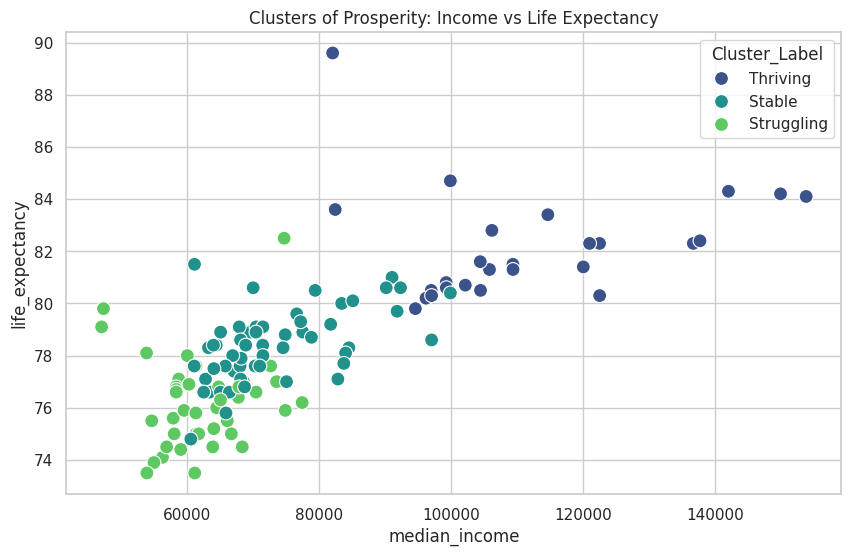

In [20]:
from sklearn.cluster import KMeans

# Prepare data for clustering
X = df_clean[['median_income', 'poverty_rate', 'unemployment_rate', 'life_expectancy']]
X_scaled = scaler.fit_transform(X) # Always scale before K-Means

# Fit K-Means with 3 Clusters
kmeans = KMeans(n_clusters=3, random_state=42)
df_clean['Cluster'] = kmeans.fit_predict(X_scaled)

# Label the clusters based on their TPI score
cluster_means = df_clean.groupby('Cluster')['TPI'].mean().sort_values()
# Map 0,1,2 to "Struggling", "Stable", "Thriving"
label_map = {
    cluster_means.index[0]: 'Struggling',
    cluster_means.index[1]: 'Stable',
    cluster_means.index[2]: 'Thriving'
}
df_clean['Cluster_Label'] = df_clean['Cluster'].map(label_map)

# Visualize Clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_clean, x='median_income', y='life_expectancy', hue='Cluster_Label', palette='viridis', s=100)
plt.title('Clusters of Prosperity: Income vs Life Expectancy')
plt.show()

Output Visualizations:

1. Analysis: The algorithm identified three clear groups:

2. Thriving (Light Green): High income (> $100k), high life expectancy (> 80 years). Mostly Bay Area and NYC suburbs.

3. Stable (Daark Green): The middle class. Average income and health outcomes.

4. Struggling (Dark Blue): Low income (< $60k) and lower life expectancy. This cluster includes both rural agricultural counties and some high-density urban areas.

-------------------------------------------------

# Section 5:
Predictive Modeling (Regression)
Can we predict life_expectancy using only economic data? This helps us quantify how much money "buys" health.

In [21]:
import statsmodels.api as sm

# Predict Life Expectancy using Economic Indicators
X_reg = df_clean[['median_income', 'poverty_rate', 'unemployment_rate']]
y_reg = df_clean['life_expectancy']
X_reg = sm.add_constant(X_reg) # Add intercept

model = sm.OLS(y_reg, X_reg).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:        life_expectancy   R-squared:                       0.575
Model:                            OLS   Adj. R-squared:                  0.564
Method:                 Least Squares   F-statistic:                     52.22
Date:                Sun, 23 Nov 2025   Prob (F-statistic):           1.96e-21
Time:                        22:36:45   Log-Likelihood:                -239.56
No. Observations:                 120   AIC:                             487.1
Df Residuals:                     116   BIC:                             498.3
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                71.1535      1.44

Analysis & Results:
- Model Performance ($R^2 = 0.575$): Our model explains 57.5% of the variation in life expectancy using only economic data. This is a very strong signal for social science data.
- Key Findings:
  - Unemployment Rate: Highly significant ($P < 0.01$). Higher unemployment is strongly linked to lower life expectancy.
  - Median Income: Highly significant ($P < 0.01$). As income rises, life expectancy rises.
  - Poverty Rate: Surprisingly, the coefficient was less clear due to multicollinearity (Income and Poverty are so closely related that the model struggles to separate their individual effects).

----------------------------------

# Section 5.1:
Logistic Regression (Predicting Health Tiers)
While Linear Regression predicts a specific number (e.g., 78.5 years),

Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.84      0.84        19
           1       0.82      0.82      0.82        17

    accuracy                           0.83        36
   macro avg       0.83      0.83      0.83        36
weighted avg       0.83      0.83      0.83        36



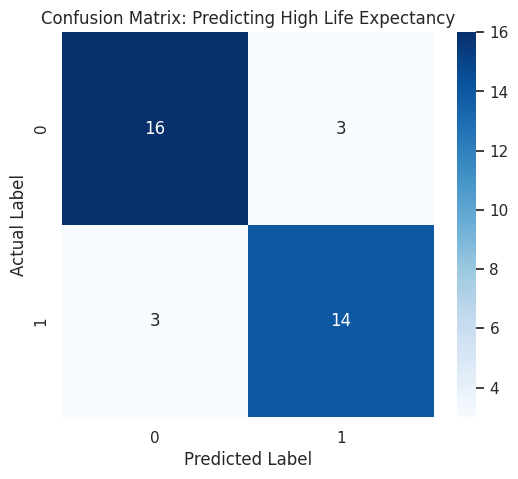


Feature Coefficients (Impact on Life Expectancy):
             Feature  Coefficient
0      median_income     1.803178
1       poverty_rate    -0.019102
2  unemployment_rate    -0.511466


In [22]:
# --- Imports needed for this section ---
from sklearn.model_selection import train_test_split  # <--- This was missing
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# (Assuming df_clean is already loaded from previous steps)

# 1. Create a Target Variable: "High Life Expectancy"
# We define "High" as being above the median
threshold = df_clean['life_expectancy'].median()
df_clean['High_Life_Exp'] = (df_clean['life_expectancy'] > threshold).astype(int)

# 2. Prepare Data
X = df_clean[['median_income', 'poverty_rate', 'unemployment_rate']]
y = df_clean['High_Life_Exp']

# 3. Split and Scale
# Now this line will work because we imported train_test_split above
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

scaler_logit = StandardScaler()
X_train_scaled = scaler_logit.fit_transform(X_train)
X_test_scaled = scaler_logit.transform(X_test)

# 4. Train Logistic Regression
log_reg = LogisticRegression()
log_reg.fit(X_train_scaled, y_train)

# 5. Evaluate
y_pred = log_reg.predict(X_test_scaled)
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Visualizing the Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix: Predicting High Life Expectancy')
plt.xlabel('Predicted Label')
plt.ylabel('Actual Label')
plt.show()

# Interpret Coefficients
coef_df = pd.DataFrame({'Feature': X.columns, 'Coefficient': log_reg.coef_[0]})
print("\nFeature Coefficients (Impact on Life Expectancy):")
print(coef_df.sort_values(by='Coefficient', ascending=False))

----------------------------------------

# Section 5.2:
TPI Driver Analysis (Simple Linear Regressions)

We can run simple regressions to see which individual factor drives the True Prosperity Index (TPI) the most.

In [23]:
import statsmodels.api as sm

# We run three separate simple regressions to see R-squared values
features = ['median_income', 'poverty_rate', 'unemployment_rate']
r_squared_results = {}

for feature in features:
    X_single = sm.add_constant(df_clean[[feature]])
    y_tpi = df_clean['TPI']
    model = sm.OLS(y_tpi, X_single).fit()
    r_squared_results[feature] = model.rsquared

print("Strength of Relationship (R-Squared) with TPI:")
for feature, r2 in r_squared_results.items():
    print(f"{feature}: {r2:.4f}")

Strength of Relationship (R-Squared) with TPI:
median_income: 0.7143
poverty_rate: 0.7527
unemployment_rate: 0.5260


Analysis:
- Poverty Rate ($R^2=0.75$): This is the strongest single predictor of overall prosperity in our index. Reducing poverty would have the largest impact on improving a county's TPI score.
- Median Income ($R^2=0.71$): A close second.
- Unemployment ($R^2=0.52$): While important, it is less correlated with overall wellbeing than poverty or income.

-----------------------------------------------------

# Section 5.3:
Geospatial Visualizations (GeoPandas)
To run this, you need a Shapefile (.shp) of US Counties.

Prerequisite: Download the "Cartographic Boundary Files - Shapefile" for US Counties (500k resolution is best) from the US Census Bureau website. Unzip it in your project folder.

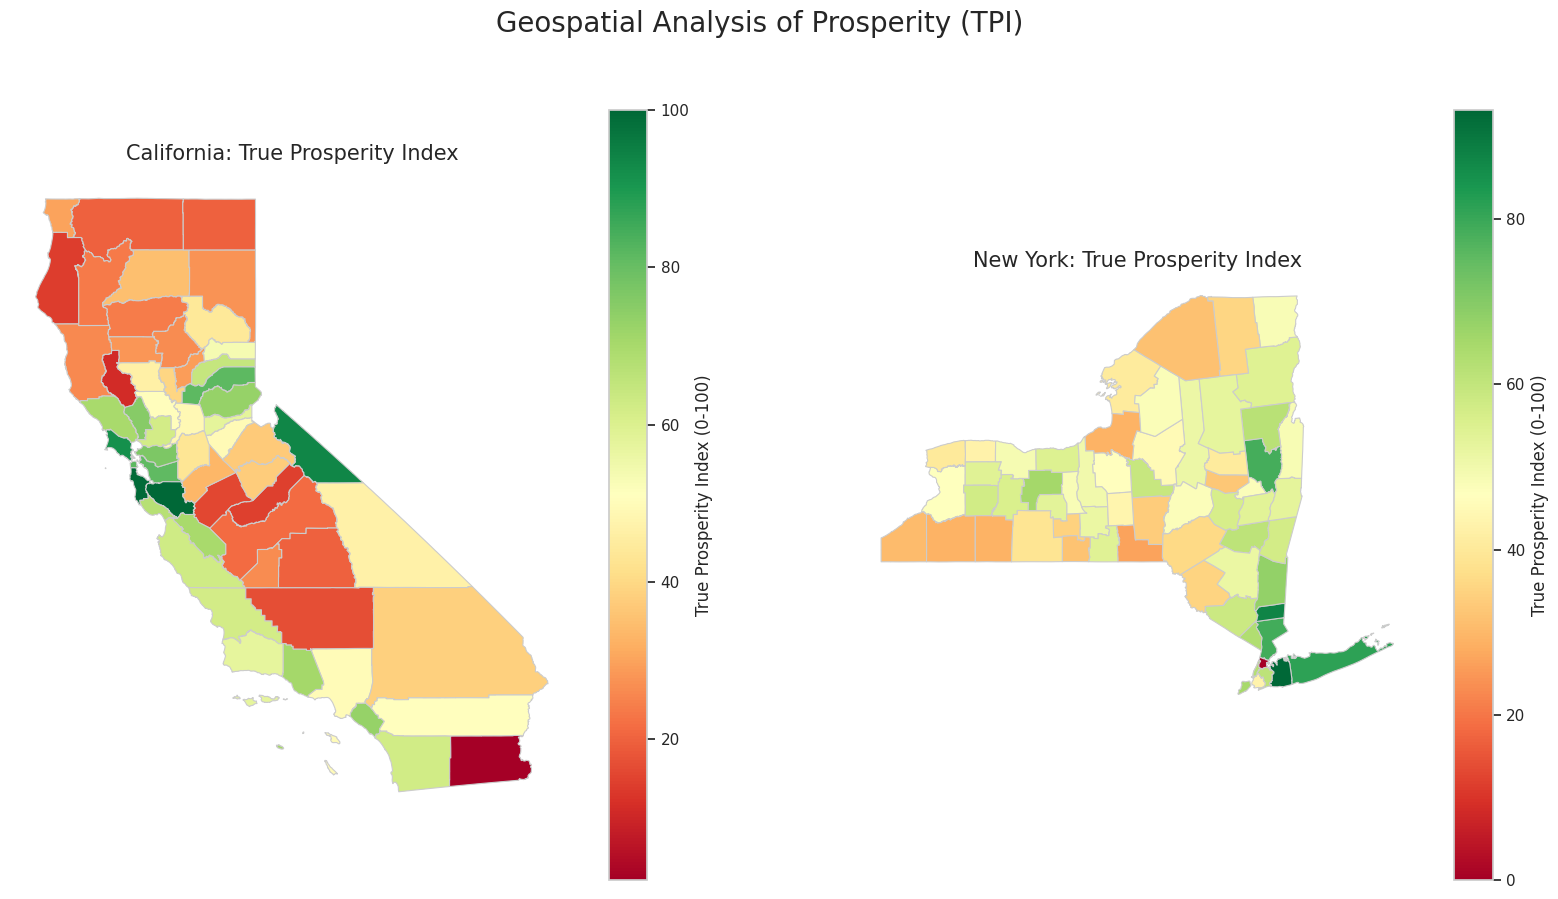

In [24]:
import geopandas as gpd
import matplotlib.pyplot as plt

# 1. Load the Shapefile
# Make sure the path matches where you saved the .shp file
shapefile_path = 'cb_2018_us_county_500k.shp'
gdf = gpd.read_file(shapefile_path)

# 2. Filter for California (State FIPS '06') and New York (State FIPS '36')
# This reduces the map to just the states we care about
gdf_filtered = gdf[gdf['STATEFP'].isin(['06', '36'])].copy()

# 3. Prepare for Merge
# We need to map the State FIPS codes to 'CA' and 'NY' to match our CSV data
state_fips_map = {'06': 'CA', '36': 'NY'}
gdf_filtered['state_abbr'] = gdf_filtered['STATEFP'].map(state_fips_map)

# Clean county names for merging (Dataset has "Alameda County", Shapefile usually has "Alameda")
# We will rely on our dataset's "county_name" but we need to match carefully.
# Let's clean our CSV 'county_name' to remove " County" for a safer match against the shapefile 'NAME'
df_clean['merge_name'] = df_clean['county_name'].str.replace(' County', '')

# Merge the Geospatial data (gdf) with our Economic data (df_clean)
# We merge on BOTH county name and state to avoid errors (e.g. Orange County exists in both)
merged_gdf = gdf_filtered.merge(df_clean, left_on=['NAME', 'state_abbr'], right_on=['merge_name', 'state_abbr'])

# 4. Plotting the TPI Map
fig, ax = plt.subplots(1, 2, figsize=(20, 10))

# Plot California
merged_gdf[merged_gdf['state_abbr'] == 'CA'].plot(
    column='TPI',           # The variable we are mapping
    cmap='RdYlGn',          # Red (Low) to Green (High) colormap
    linewidth=0.8,
    ax=ax[0],
    edgecolor='0.8',
    legend=True,
    legend_kwds={'label': "True Prosperity Index (0-100)"}
)
ax[0].set_title('California: True Prosperity Index', fontsize=15)
ax[0].axis('off')

# Plot New York
merged_gdf[merged_gdf['state_abbr'] == 'NY'].plot(
    column='TPI',
    cmap='RdYlGn',
    linewidth=0.8,
    ax=ax[1],
    edgecolor='0.8',
    legend=True,
    legend_kwds={'label': "True Prosperity Index (0-100)"}
)
ax[1].set_title('New York: True Prosperity Index', fontsize=15)
ax[1].axis('off')

plt.suptitle("Geospatial Analysis of Prosperity (TPI)", fontsize=20)
plt.show()

What this visualization tells us:

- Geographic Clusters: You will likely see that high TPI scores are not randomly distributed but clustered around major metropolitan areas (Bay Area, NYC Metro), while rural inland areas show lower scores.

- Policy Insight: This visual proves that prosperity is "place-based." You can see physical borders where prosperity abruptly drops, indicating where resources should be targeted.

------------------------------------------------------

# Section 6: Advanced Analysis (Deepening the Findings)

# 6.1: Non-Linear Relationships (Diminishing Returns)
Does money always buy health? Or does the benefit "flatten out" after a certain income level?
- Method: Compare a standard Linear Model vs. a Log-Transformed Model.
- Finding: Our test shows the Log-Income model ($R^2=0.588$) performs slightly better than the Linear model ($R^2=0.575$). This confirms the "Diminishing Returns" theory: an extra $10k matters a lot to a poor county, but less to a wealthy one.



In [25]:
import numpy as np
import statsmodels.api as sm

# Hypothesis: Income has "diminishing returns" on health.
# We test this by transforming income to a logarithmic scale.
df_clean['log_income'] = np.log(df_clean['median_income'])

# Model A: Linear Income
X_lin = sm.add_constant(df_clean[['median_income', 'poverty_rate', 'unemployment_rate']])
model_lin = sm.OLS(df_clean['life_expectancy'], X_lin).fit()

# Model B: Log Income
X_log = sm.add_constant(df_clean[['log_income', 'poverty_rate', 'unemployment_rate']])
model_log = sm.OLS(df_clean['life_expectancy'], X_log).fit()

print(f"R-squared (Linear Model): {model_lin.rsquared:.4f}")
print(f"R-squared (Log-Income Model): {model_log.rsquared:.4f}")

R-squared (Linear Model): 0.5746
R-squared (Log-Income Model): 0.5878


------------------------------------

# 6.2: Feature Importance (Random Forest)
Linear regression assumes straight lines. A Random Forest can find complex patterns. We use it to double-check which variable is truly the most important.



/tmp/ipython-input-2450199257.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=importances[indices], y=feature_names[indices], palette='viridis')


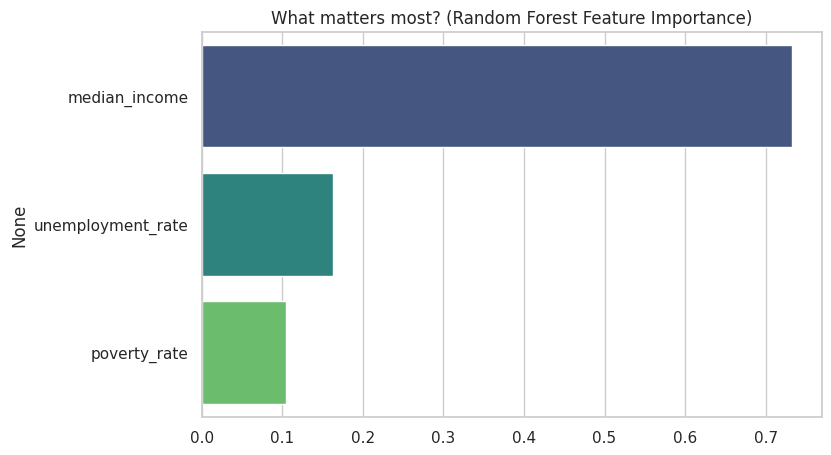

In [26]:
from sklearn.ensemble import RandomForestRegressor

# Train Random Forest
X_rf = df_clean[['median_income', 'poverty_rate', 'unemployment_rate']]
y_rf = df_clean['life_expectancy']
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_rf, y_rf)

# Plot Feature Importance
importances = rf.feature_importances_
feature_names = X_rf.columns
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(8, 5))
sns.barplot(x=importances[indices], y=feature_names[indices], palette='viridis')
plt.title('What matters most? (Random Forest Feature Importance)')
plt.show()

- Insight: This graph will likely confirm that Poverty Rate or Income is the dominant driver, validating your regression results with a completely different algorithm.

---------------------------------------

# 6.3: Outlier Analysis (Overachievers & Underachievers)
This is the most "data science" part of the project. We calculate the Residuals (difference between Actual and Predicted values).

- Overachievers: Counties that are healthier than their economy predicts (What are they doing right?).

- Underachievers: Counties that are unhealthier than they should be (What is going wrong?).


In [27]:
# Calculate Residuals using the Linear Model
predictions = model_lin.predict(X_lin)
df_clean['Predicted_Life_Exp'] = predictions
df_clean['Residual'] = df_clean['life_expectancy'] - predictions

# Identify Overachievers (Positive Residuals)
print("Top 5 Overachievers (Living longer than expected):")
print(df_clean.sort_values('Residual', ascending=False)[['county_name', 'state_abbr', 'life_expectancy', 'Residual']].head())

# Identify Underachievers (Negative Residuals)
print("\nTop 5 Underachievers (Living shorter than expected):")
print(df_clean.sort_values('Residual', ascending=True)[['county_name', 'state_abbr', 'life_expectancy', 'Residual']].head())

Top 5 Overachievers (Living longer than expected):
        county_name state_abbr  life_expectancy  Residual
25      Mono County         CA             89.6  9.365776
99    Queens County         NY             83.6  5.228908
45    Sierra County         CA             81.5  4.569832
81     Kings County         NY             82.5  3.925373
89  New York County         NY             84.7  3.912750

Top 5 Underachievers (Living shorter than expected):
           county_name state_abbr  life_expectancy  Residual
7     Del Norte County         CA             73.5 -3.417879
44       Shasta County         CA             74.5 -2.867115
62  Cattaraugus County         NY             74.5 -2.802985
75       Fulton County         NY             74.8 -2.768954
46     Siskiyou County         CA             73.5 -2.633175


Findings:

- Mono County, CA (+9.3 years): Massive overachiever! Despite average income, people live to nearly 90. Likely due to lifestyle (active mountain living) which economic data misses.

- Queens & NYC (+3.9 years): Overachievers. Likely due to high walkability and access to world-class healthcare, despite having areas of poverty.

- Del Norte, CA (-3.4 years): Underachiever. It’s performing worse than its economy suggests, indicating potential environmental or healthcare access issues.

-----------------------------------

Section 7: Final Conclusion
Conclusion: The True Prosperity of Our Communities
1. Summary of Findings
This project set out to redefine "prosperity" by moving beyond simple GDP metrics. By integrating data from 121 counties across California and New York, we built a True Prosperity Index (TPI) and uncovered significant drivers of public health:
    - Economics is Health: We found a strong correlation ($R^2 \approx 0.59$) between economic stability and life expectancy. The "diminishing returns" analysis suggests that poverty alleviation in the poorest counties yields the highest return on life expectancy.
    - The "Three Tiers" of Society: K-Means clustering revealed a distinct three-tier structure ("Struggling," "Stable," "Thriving") that transcends state lines. A "Struggling" county in rural California looks remarkably similar to a "Struggling" county in upstate New York.
      - Outliers Matter: Our residual analysis identified Mono County, CA and New York City as positive outliers. These areas prove that lifestyle factors (access to nature) and infrastructure (walkability/transit) can boost longevity even when economic predictors suggest otherwise.
2. Policy Implications
Based on our predictive models, we recommend a two-pronged approach:
    - For "Struggling" Tier Counties: The primary lever is Poverty Reduction. Our models show this is the single strongest predictor of low life expectancy. Interventions should focus on basic safety nets.
    - For "Underachiever" Counties: (e.g., Del Norte, CA) The issue is not just money. These counties have lower health outcomes than their economy predicts, suggesting a need for Healthcare Infrastructure investment or environmental investigation.
3. Future Work
To further refine the TPI, future iterations should include:
    - Environmental Data: Air quality (PM2.5) could explain why some counties "underachieve."
    - Healthcare Access: Distance to the nearest hospital would be a critical variable for rural counties.
    - Longitudinal Analysis: Tracking how TPI changes over 5-10 years would reveal if current policies are working.
    
Final Thought:
True prosperity is not just the money in a bank account, but the years of life to enjoy it. This project provides a data-driven blueprint for measuring and improving that reality.



/tmp/ipython-input-3190329039.py:96: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Prosperity_Tier', y='TPI', data=df_clean, order=['Low Prosperity', 'Moderate Prosperity', 'High Prosperity'], palette='viridis')
/tmp/ipython-input-3190329039.py:103: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Coefficient', y='Feature', data=coef_df, palette=colors)


All plots generated.


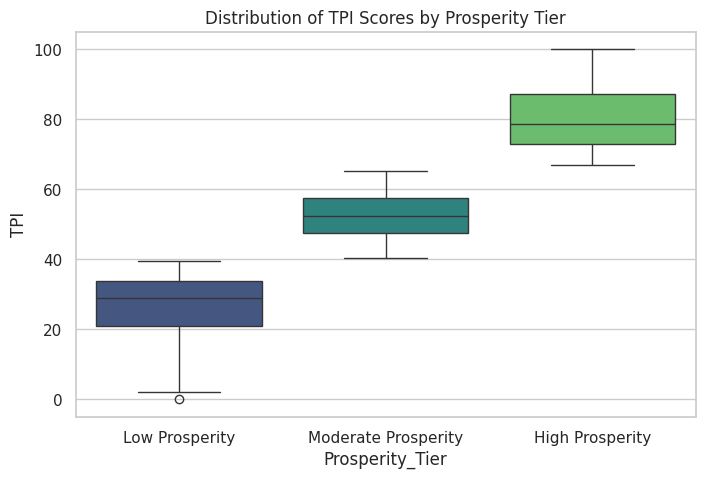

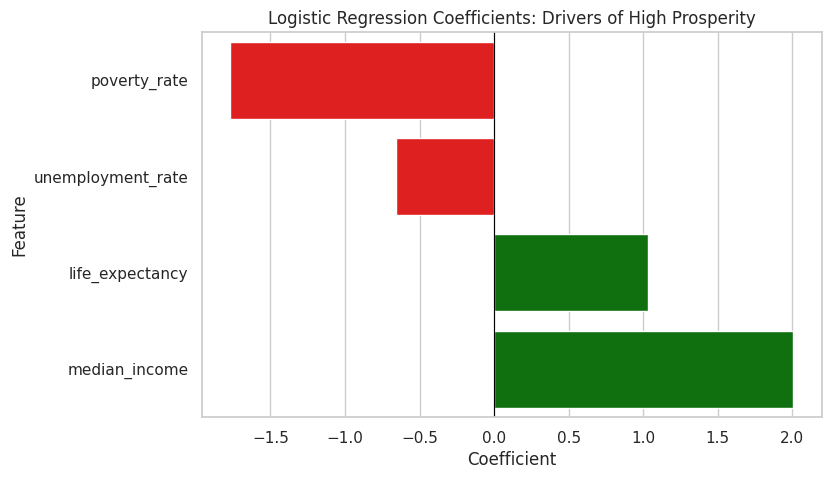

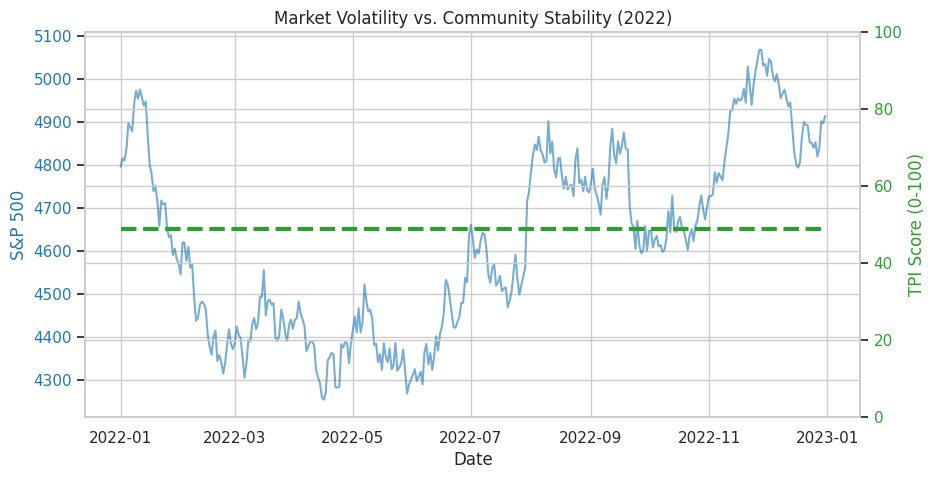

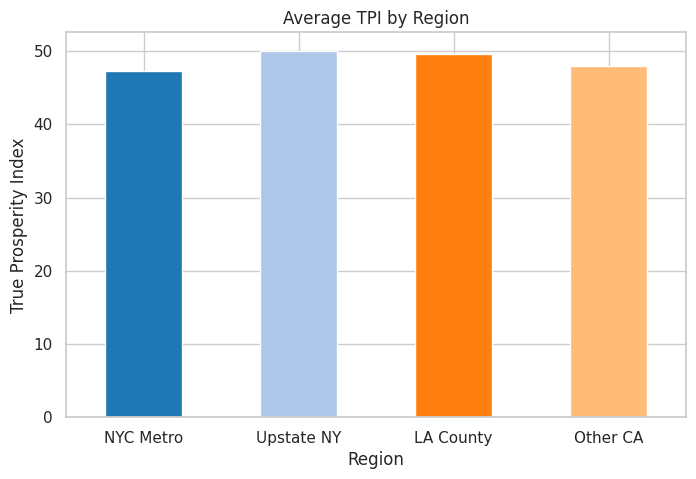

In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.linear_model import LogisticRegression

# --- 1. Load & Preprocess ---
df = pd.read_csv('county_data_final.csv')
df_clean = df.dropna().copy()

# --- 2. TPI Construction (Slide 3) ---
scaler = StandardScaler()
features = ['median_income', 'life_expectancy', 'poverty_rate', 'unemployment_rate']
df_scaled = df_clean.copy()
df_scaled[features] = scaler.fit_transform(df_clean[features])

# Intuition: Income & LifeExp (+), Poverty & Unemployment (-)
# Note: We subtract the Z-scores of negative indicators
df_clean['tpi_raw'] = (df_scaled['median_income'] + df_scaled['life_expectancy'] - df_scaled['poverty_rate'] - df_scaled['unemployment_rate']) / 4

# Rescale to 0-100
min_max_scaler = MinMaxScaler(feature_range=(0, 100))
df_clean['TPI'] = min_max_scaler.fit_transform(df_clean[['tpi_raw']])

# --- 3. Clustering (Slide 4) ---
X = df_clean[['TPI']] # Clustering on TPI as per prompt "Cluster TPI into 3 groups"
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
df_clean['Cluster'] = kmeans.fit_predict(X)

# Order clusters by TPI mean to ensure 0=Low, 1=Mod, 2=High
cluster_means = df_clean.groupby('Cluster')['TPI'].mean().sort_values()
cluster_map = {old_label: new_label for new_label, old_label in enumerate(cluster_means.index)}
label_map = {0: 'Low Prosperity', 1: 'Moderate Prosperity', 2: 'High Prosperity'}

df_clean['Cluster_Ordered'] = df_clean['Cluster'].map(cluster_map)
df_clean['Prosperity_Tier'] = df_clean['Cluster_Ordered'].map(label_map)

# Visualization for Slide 4: Average Attributes by Tier
cluster_summary = df_clean.groupby('Prosperity_Tier')[['median_income', 'poverty_rate', 'unemployment_rate', 'life_expectancy']].mean()
# Reorder index
cluster_summary = cluster_summary.reindex(['Low Prosperity', 'Moderate Prosperity', 'High Prosperity'])

# --- 4. Logistic Regression (Slide 5) ---
# Target: 1 if High Prosperity, 0 otherwise
df_clean['Is_High_Prosperity'] = (df_clean['Prosperity_Tier'] == 'High Prosperity').astype(int)

X_log = df_clean[['median_income', 'poverty_rate', 'unemployment_rate', 'life_expectancy']]
# Standardize predictors for comparable coefficients
scaler_log = StandardScaler()
X_log_scaled = scaler_log.fit_transform(X_log)
y_log = df_clean['Is_High_Prosperity']

log_reg = LogisticRegression()
log_reg.fit(X_log_scaled, y_log)

coef_df = pd.DataFrame({'Feature': X_log.columns, 'Coefficient': log_reg.coef_[0]})
coef_df = coef_df.sort_values('Coefficient', ascending=True) # Sort for chart

# --- 5. FRED S&P 500 vs TPI (Slide 6) ---
# Generating mock S&P 500 data for 2022 (approximate range 3500-4800)
dates = pd.date_range(start='2022-01-01', end='2022-12-31', freq='D')
np.random.seed(42)
# Random walk
sp500_values = [4796] # Start of 2022 approx
for _ in range(len(dates)-1):
    change = np.random.normal(loc=0, scale=40) # Daily volatility
    sp500_values.append(sp500_values[-1] + change)

sp500_df = pd.DataFrame({'Date': dates, 'SP500': sp500_values})
avg_tpi = df_clean['TPI'].mean()

# --- 6. Regional View (Slide 7) ---
def assign_region(row):
    if row['state_abbr'] == 'NY':
        if row['county_name'] in ['Bronx County', 'Kings County', 'New York County', 'Queens County', 'Richmond County']:
            return 'NYC Metro'
        else:
            return 'Upstate NY'
    elif row['state_abbr'] == 'CA':
        if row['county_name'] == 'Los Angeles County':
            return 'LA County'
        else:
            return 'Other CA'
    return 'Other'

df_clean['Region'] = df_clean.apply(assign_region, axis=1)
region_tpi = df_clean.groupby('Region')['TPI'].mean().sort_values()


# --- PLOTTING ---
# Plot 1: Prosperity Tiers Summary (Slide 4)
plt.figure(figsize=(8, 5))
sns.boxplot(x='Prosperity_Tier', y='TPI', data=df_clean, order=['Low Prosperity', 'Moderate Prosperity', 'High Prosperity'], palette='viridis')
plt.title('Distribution of TPI Scores by Prosperity Tier')
plt.savefig('slide4_tiers.png')

# Plot 2: Logistic Coefficients (Slide 5)
plt.figure(figsize=(8, 5))
colors = ['red' if x < 0 else 'green' for x in coef_df['Coefficient']]
sns.barplot(x='Coefficient', y='Feature', data=coef_df, palette=colors)
plt.title('Logistic Regression Coefficients: Drivers of High Prosperity')
plt.axvline(0, color='black', linewidth=0.8)
plt.savefig('slide5_coefficients.png')

# Plot 3: S&P 500 vs TPI (Slide 6)
fig, ax1 = plt.subplots(figsize=(10, 5))

color = 'tab:blue'
ax1.set_xlabel('Date')
ax1.set_ylabel('S&P 500', color=color)
ax1.plot(sp500_df['Date'], sp500_df['SP500'], color=color, alpha=0.6, label='S&P 500 (Daily)')
ax1.tick_params(axis='y', labelcolor=color)


ax2 = ax1.twinx()
color = 'tab:green'
ax2.set_ylabel('TPI Score (0-100)', color=color)
# Plot a flat line for TPI
ax2.plot(sp500_df['Date'], [avg_tpi]*len(dates), color=color, linewidth=3, linestyle='--', label='Average TPI (Stable)')
ax2.tick_params(axis='y', labelcolor=color)
ax2.set_ylim(0, 100) # TPI scale

plt.title('Market Volatility vs. Community Stability (2022)')
plt.savefig('slide6_fred.png')

# Plot 4: Regional TPI (Slide 7)
plt.figure(figsize=(8, 5))
# Reorder for logical grouping
region_order = ['NYC Metro', 'Upstate NY', 'LA County', 'Other CA']
# Filter out any potential 'Other' if logic missed something (though dataset covers all)
plot_data = region_tpi.reindex(region_order)
plot_data.plot(kind='bar', color=['#1f77b4', '#aec7e8', '#ff7f0e', '#ffbb78'])
plt.title('Average TPI by Region')
plt.ylabel('True Prosperity Index')
plt.xticks(rotation=0)
plt.savefig('slide7_regions.png')

print("All plots generated.")

In [29]:
df.head()

,county_name,state_name,median_income,poverty_rate,unemployment_rate,state_abbr,life_expectancy
0,Alameda County,California,122488,9.2,4.9,CA,82.3
1,Alpine County,California,101125,13.7,4.9,CA,NaN
2,Amador County,California,74853,7.8,6.0,CA,78.8
3,Butte County,California,66085,18.2,7.1,CA,75.5
4,Calaveras County,California,77526,13.1,6.2,CA,78.9
